This notebook will show the implementation of RangingNN for generating peaks ranges in a APT mass-to-charge spectrum, including

- load the apt file into arrays
- preprocessing: normalizaton of M/C values and the counts
- load model
- run model inference
- plot the ranges and compare with mannual labeling

# Import modules

**! For a new python environment, please install the apav package first for reading the apt and rrng files**

**! change the file path according to your file directory**

In [13]:
import apav
from RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
def normalize(spectrum, ranges):
    return (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()), ranges / 307.2

# Load data and preprocessing

In [42]:
apt_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/R13_40310Zr Top Level ROI.apt'
range_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/ExaminedRanges/R13_40310Zr Top Level ROI.RRNG'

#load the apt and get histogram
d = apav.load_apt(apt_file)
x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False, )

#load the rrng and labeled peaks
range_label = apav.RangeCollection.from_rrng(range_file)
peakl = np.array([r.lower for r in range_label.ranges])
peakh = np.array([r.upper for r in range_label.ranges])
peaks = np.vstack((peakl, peakh)).T

spectrum_log = np.log(spectrum+1)
spectrum_log, range_gt = normalize(spectrum_log, peaks)
spectrum_log = torch.tensor(spectrum_log, dtype=torch.float32) 

# Load model and run inference

In [43]:
cfg = '/srv/home/jwei74/APT_ML/ranging/prediction_args.yaml'
save_dir = './test'
modelpath= "/srv/home/jwei74/APT_ML/ranging/training_results0/weights/best.pt"

predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = save_dir, cfg = cfg)
result = predictor()[0]
peak_pred = result[:,:2].cpu()

Start inference
Speed:  2021.1ms inference, 11.2ms postprocess for per spectrum 


# Visualization

In [47]:
%matplotlib widget 
# enabling interactive plot

labeled peaks: 33 ; model predicted peaks: 35


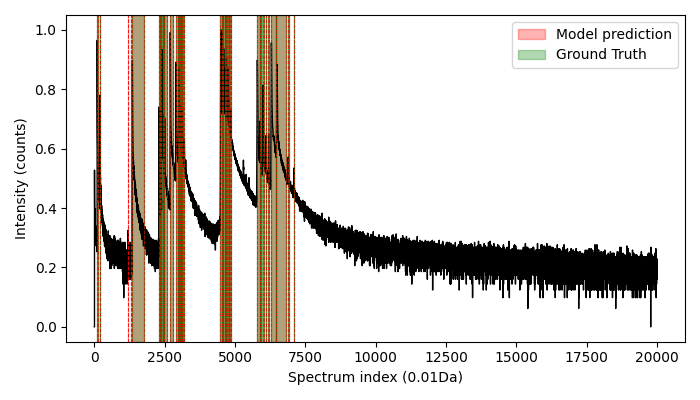

In [49]:
# set the zoom in m/c range
plot_max = 20000 # in 0.01 Da
plot_min = 0
bin_width =0.01
peak_pred_ = peak_pred[(peak_pred[:,0] < plot_max) & (peak_pred[:,0] >plot_min)]

peaks_ = peaks / bin_width # scale the labels
peaks_ = peaks_[(peaks[:,0] < plot_max) & (peaks[:,0] >plot_min)]
print('labeled peaks:', peaks.shape[0],'; model predicted peaks:',peak_pred.shape[0] )

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the spectrum
x = torch.linspace(plot_min,plot_max, plot_max - plot_min)

ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


# Add color boxes for each peak range
# Add vertical lines to show the boundaries of ranges

for start, end in peak_pred_:
    ax.axvspan(start, end, alpha=0.3, color='red',label='Model prediction' if start == peak_pred[0][0] else "")
for start, end in peak_pred_:
    ax.axvline(start, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end, color='red', linestyle='--', alpha=0.7, lw = 0.7)

    
for start, end in peaks_:
    ax.axvspan(start, end, alpha=0.3, color='green',label='Ground Truth'if start == peaks_[0][0] else "")
for start, end in peaks_:
    ax.axvline(start, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    ax.axvline(end, color='green', linestyle=':', alpha=0.7, lw = 0.5)
    
# Set labels and title
ax.set_xlabel('Spectrum index (0.01Da)')
ax.set_ylabel('Intensity (counts)')

# Adjust the plot layout
plt.tight_layout()
plt.legend()